<a href="https://colab.research.google.com/github/venkatesh-r96/Quality-Assurance-in-Casting-Product/blob/main/Casting_Quality_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Defect Detection for Quality Assurance in Casting Product**

# **The Problem: Casting Defects**

# **Manual Inspection Challenges**



Casting defects are undesired irregularities that can occur during the metal casting process. These defects come in various forms, including **blow holes, pinholes, burrs, shrinkage defects, mold material defects, pouring metal defects, metallurgical defects,** and more. In the casting industry, defects are unwelcome occurrences, as they compromise the quality of the final product.






**The Dataset's Role**
This dataset plays a pivotal role in our mission. It serves as the foundation upon which we are building machine learning models and artificial intelligence algorithms. By analyzing this data, we aim to train models that can automatically detect and classify casting defects. These models will not only expedite the inspection process but also enhance its accuracy, reducing the likelihood of costly rejections.





To ensure product quality, casting industries typically employ manual inspection processes. However, this approach is not without its drawbacks. Manual inspections are time-consuming, and they rely on human accuracy, which may not always be 100% reliable. The consequences of missed defects can be severe, potentially leading to the rejection of entire orders and substantial financial losses for the company.

# **Dataset Description:**



The images included in this dataset depict top views of submersible pump impellers, making it a specialized collection tailored to addressing casting quality issues in this specific context.


These all photos are top view of submersible pump impeller

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers

In [ ]:
!nvidia-smi

Sat Sep 30 08:17:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the Data**

In [ ]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Data Science/casting',
    shuffle= True,
    image_size= (300,300),
    batch_size= 32)

Found 7247 files belonging to 2 classes.


In [ ]:
class_names = df.class_names
class_names

['correct_front', 'defective_front']

In [ ]:
len(df)

227

**Data Visualization**

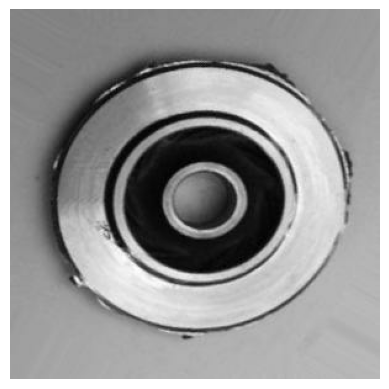

In [ ]:
for image_batch, label_batch in df.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.axis('off')

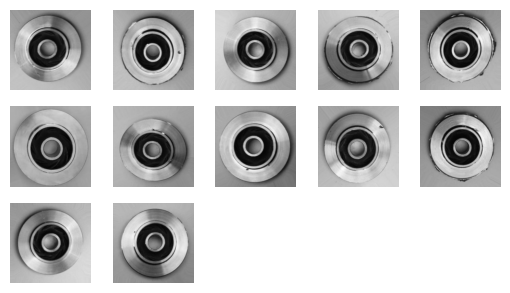

In [ ]:
for image_batch, label_batch in df.take(1):
  for i in range(12):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
len(df)

227

# Train Test Split

In [ ]:
# 80% = training
# 20% => 10% validation, 10% test

train_size = 0.8
len(df)*train_size

181.60000000000002

In [ ]:
train_ds = df.take(182)
len(train_ds)

182

In [ ]:
test_ds = df.skip(182)
len(test_ds)

45

In [ ]:
val_size = 0.1
len(df)*val_size

22.700000000000003

In [ ]:
val_ds = test_ds.take(22)
len(val_ds)

22

In [ ]:
test_ds = test_ds.skip(22)
len(test_ds)

23

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size , seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds , test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [ ]:
len(train_ds)

181

In [ ]:
len(test_ds)

24

In [ ]:
len(val_ds)

22

**Data set optimization to increase the training performance**

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

# Data Preprocessing

RGB value is 256. so we are changing image size to 256*256

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(300,300),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data Agumentation

In [ ]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Buliding - Convolution Neural Network

In [ ]:
input_shape = (32, 300,300,3)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 149, 149, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 73, 73, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

**Fit the dataset into Model**

In [ ]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
181/181 [==============================] - 49s 114ms/step - loss: 0.6001 - accuracy: 0.6462 - val_loss: 0.3834 - val_accuracy: 0.8201
Epoch 2/50
181/181 [==============================] - 18s 101ms/step - loss: 0.2666 - accuracy: 0.8904 - val_loss: 0.1888 - val_accuracy: 0.9314
Epoch 3/50
181/181 [==============================] - 18s 102ms/step - loss: 0.1555 - accuracy: 0.9415 - val_loss: 0.0841 - val_accuracy: 0.9725
Epoch 4/50
181/181 [==============================] - 18s 102ms/step - loss: 0.1121 - accuracy: 0.9609 - val_loss: 0.1584 - val_accuracy: 0.9335
Epoch 5/50
181/181 [==============================] - 19s 103ms/step - loss: 0.0737 - accuracy: 0.9733 - val_loss: 0.0436 - val_accuracy: 0.9874
Epoch 6/50
181/181 [==============================] - 19s 102ms/step - loss: 0.0356 - accuracy: 0.9898 - val_loss: 0.0475 - val_accuracy: 0.9867
Epoch 7/50
181/181 [==============================] - 18s 102ms/step - loss: 0.0454 - accuracy: 0.9863 - val_loss: 0.0271 - val_ac

In [ ]:
scores = model.evaluate(test_ds)

181/181 [==============================] - 5s 27ms/step - loss: 0.0087 - accuracy: 0.9977


In [ ]:
scores

[0.00871746614575386, 0.9977489113807678]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 181}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']

# Ploting the Model Accuracy

Text(0.5, 1.0, 'Training and Validation Loss')

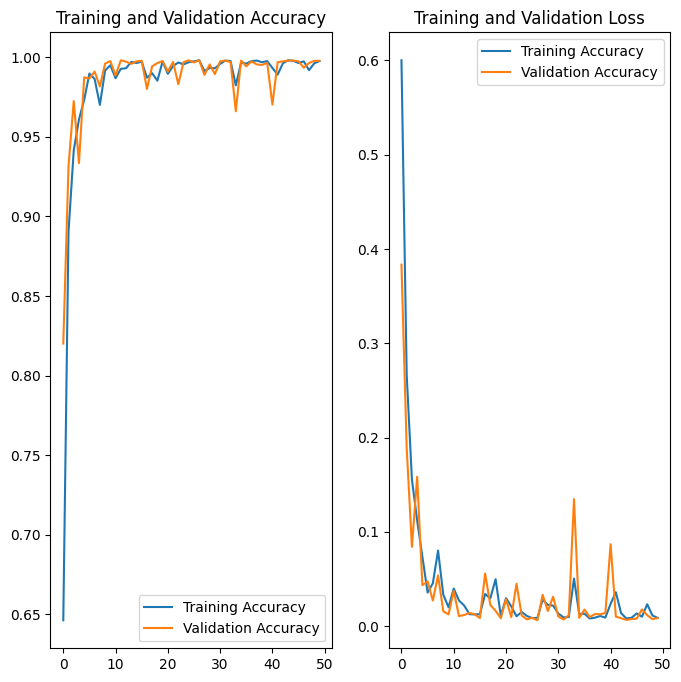

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label = 'Training Accuracy')
plt.plot(range(50), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label = 'Training Accuracy')
plt.plot(range(50), val_loss, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: defective_front
1/1 [==============================] - 0s 236ms/step
predicted label: defective_front


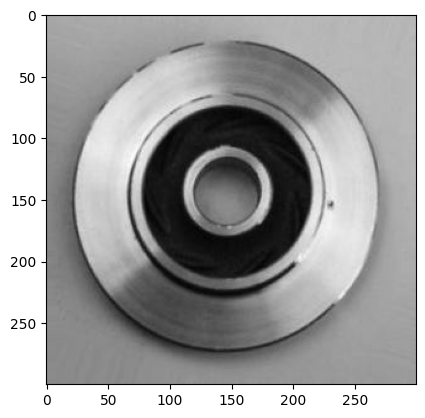

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round (100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

**Checking the Models Confidence level**

1/1 [==============================] - 0s 27ms/step


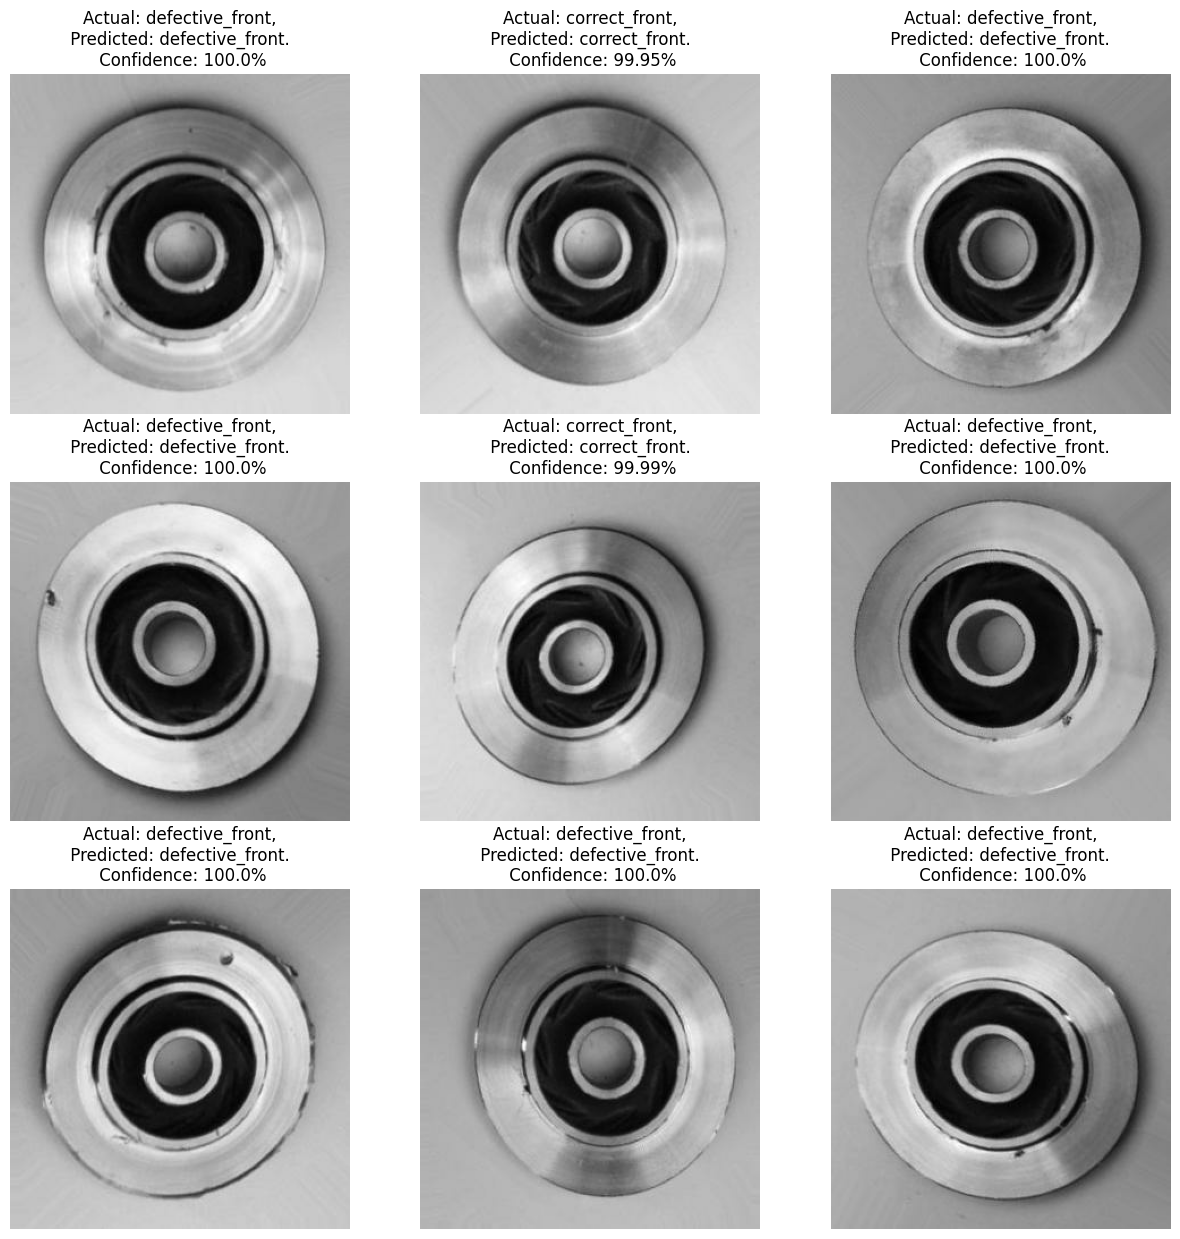

In [ ]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")
    plt.axis("off")


# **Model gave the prediction with highest accuracy **

**A Vision for Improvement**
Recognizing the need for a more efficient and accurate inspection process, we embarked on a journey to harness the power of data and automation. Our goal is to revolutionize the casting manufacturing industry by creating a system that can identify defects with unparalleled precision and speed.